In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import spacy
import re
import string

In [2]:
#Load variants database
training_variants = pd.read_csv("data_files/training_variants")
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
#Analyse variables
training_variants.describe(include='all')

,ID,Gene,Variation,Class
count,3321.000000,3321,3321,3321.000000
unique,NaN,264,2996,NaN
top,NaN,BRCA1,Truncating Mutations,NaN
freq,NaN,264,93,NaN
mean,1660.000000,NaN,NaN,4.365854
std,958.834449,NaN,NaN,2.309781
min,0.000000,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,7.000000


<Axes: >

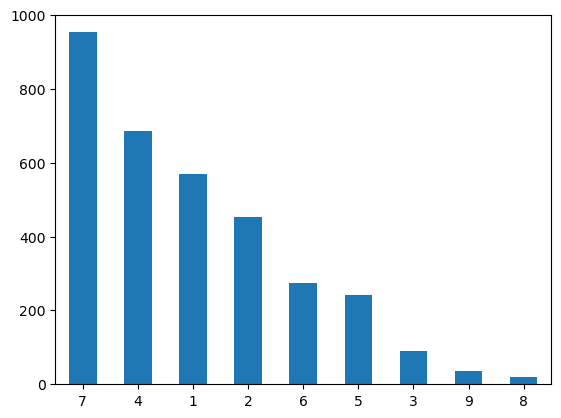

In [4]:
#Visualize class distribuition
training_variants["Class"].value_counts().plot(kind="bar", rot=0)

In [5]:
#load text database
training_text = pd.read_csv('data_files/training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
training_text.head()

C:\Users\gab\AppData\Local\Temp\ipykernel_7216\1663612606.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  training_text = pd.read_csv('data_files/training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
#Visualize full text from one row
training_text["Text"].iloc[0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

In [7]:
#Merge databases
df_train = pd.merge(training_variants, training_text, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
#Remove nulls texts
df_train = df_train[df_train["Text"].notnull()]

In [9]:
#Count words on text
df_train.loc[:, 'Text_count']  = df_train["Text"].apply(lambda x: len(x.split()))
df_train.head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202


In [10]:
#Visualize registries with less than 250 words
df_train[df_train["Text_count"]<250.0]

,ID,Gene,Variation,Class,Text,Text_count
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,187
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,187
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,187
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ...",103
688,688,CDKN2A,R79P,4,Cell division is controlled by a series of pos...,228
692,692,CDKN2A,G93W,4,Cell division is controlled by a series of pos...,228
693,693,CDKN2A,V118D,4,Cell division is controlled by a series of pos...,228
868,868,HLA-A,596_619splice,1,A new variant of the HLA-A*010101 allele desig...,184
941,941,PDGFRB,ATF7IP-PDGFRB Fusion,2,Chronic myelomonocytic leukemia (CMML) is a my...,116
1057,1057,EWSR1,EWSR1-FEV Fusion,2,"As a result of chromosome translocations, the ...",207


In [11]:
#Visualize smallest text regitry
df_train["Text"].loc[1613]

'The case of a 40-year-old woman with severe edema of the face and neck after the injection of a local dental anesthetic is presented. The reaction is attributed to the presence of sodium metabisulfite, and antioxidant, in the local anesthetic. Both the anesthetic and the sodium metabisulfite gave a delayed positive patch-test response.'

In [47]:
#Tokenize the text to words
df_train["Words"] = df_train["Text"].apply(word_tokenize)

In [48]:
#Remove stopwords
english_stops = set(stopwords.words('english'))
df_train["Words"] = df_train["Words"].apply(lambda x: [item for item in x if item not in english_stops])

In [49]:
#Remove other invalid registries
stops = set(["(",")",",",".","-"])
df_train["Words"] = df_train["Words"].apply(lambda x: [item for item in x if item not in stops])

In [54]:
# Carrega o dcionário em nossa sessão SpaCy
nlp = spacy.load("en_core_web_sm")

In [58]:
# Função para limpar e lematizar os comentários
def limpa_comentarios(text):
    
    # Remove pontuação usando expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    
    # Usa o SpaCy para lematização
    doc = nlp(nopunct, disable = ['parser', 'ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [59]:
# Aplica a função aos dados
comentarios_ingles_lemmatized = df_train["Text"].map(limpa_comentarios)

In [60]:
comentarios_ingles_lemmatized

0       [Cyclin, dependent, kinase,  , cdk,  , regulat...
1       [ , Abstract, Background,  , Non, small, cell,...
2       [ , Abstract, Background,  , Non, small, cell,...
3       [recent, evidence, have, demonstrate, that, ac...
4       [oncogenic, mutation, in, the, monomeric, Casi...
                              ...                        
3316    [introduction,  , Myelodysplastic, syndrome,  ...
3317    [introduction,  , Myelodysplastic, syndrome,  ...
3318    [the, Runt, relate, transcription, factor, 1, ...
3319    [the, RUNX1, AML1, gene, be, the, most, freque...
3320    [the, most, frequent, mutation, associate, wit...
Name: Text, Length: 3316, dtype: object